In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL.Image

Implement IG step by step

In [18]:
img_size = (224,224)
input_size = (224,224,3)
img_path = "fireboat.jpg"
class_index = 555
m_steps = 240
alpha = 0.4
model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=True, weights="imagenet", input_shape=input_size)
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [19]:
def interpolation(base, img, alphas):
    # convert alpha from 1D to 4D
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]

    # add batchsize, shape will be (batch, h, w, channel)
    base_x = tf.expand_dims(base, axis=0)
    input_x = tf.expand_dims(img, axis=0)

    delta = input_x - base_x
    images = base_x + alphas_x * delta
    return images

def compute_grad(images, class_index):
   with tf.GradientTape() as tape:
      tape.watch(images)
      logits = model(images)
      probs = tf.nn.softmax(logits, axis=-1)[:, class_index]
      return tape.gradient(probs, images)

def integral_approximation(gradients):
  # riemann_trapezoidal   ([(x[0]+x[1])/2.0] + [....] + [...] )/m
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

def integrated_gradients(baseline,
                         image,
                         class_index,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, class_index)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

@tf.function
def one_batch(baseline, image, alpha_batch, class_index):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolation(base=baseline,
                                                       img=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_grad(images=interpolated_path_input_batch,
                                       class_index=class_index)
    return gradient_batch

def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=img_size)
  return image

<class 'tensorflow.python.framework.ops.EagerTensor'>


Text(0.5, 1.0, 'Baseline')

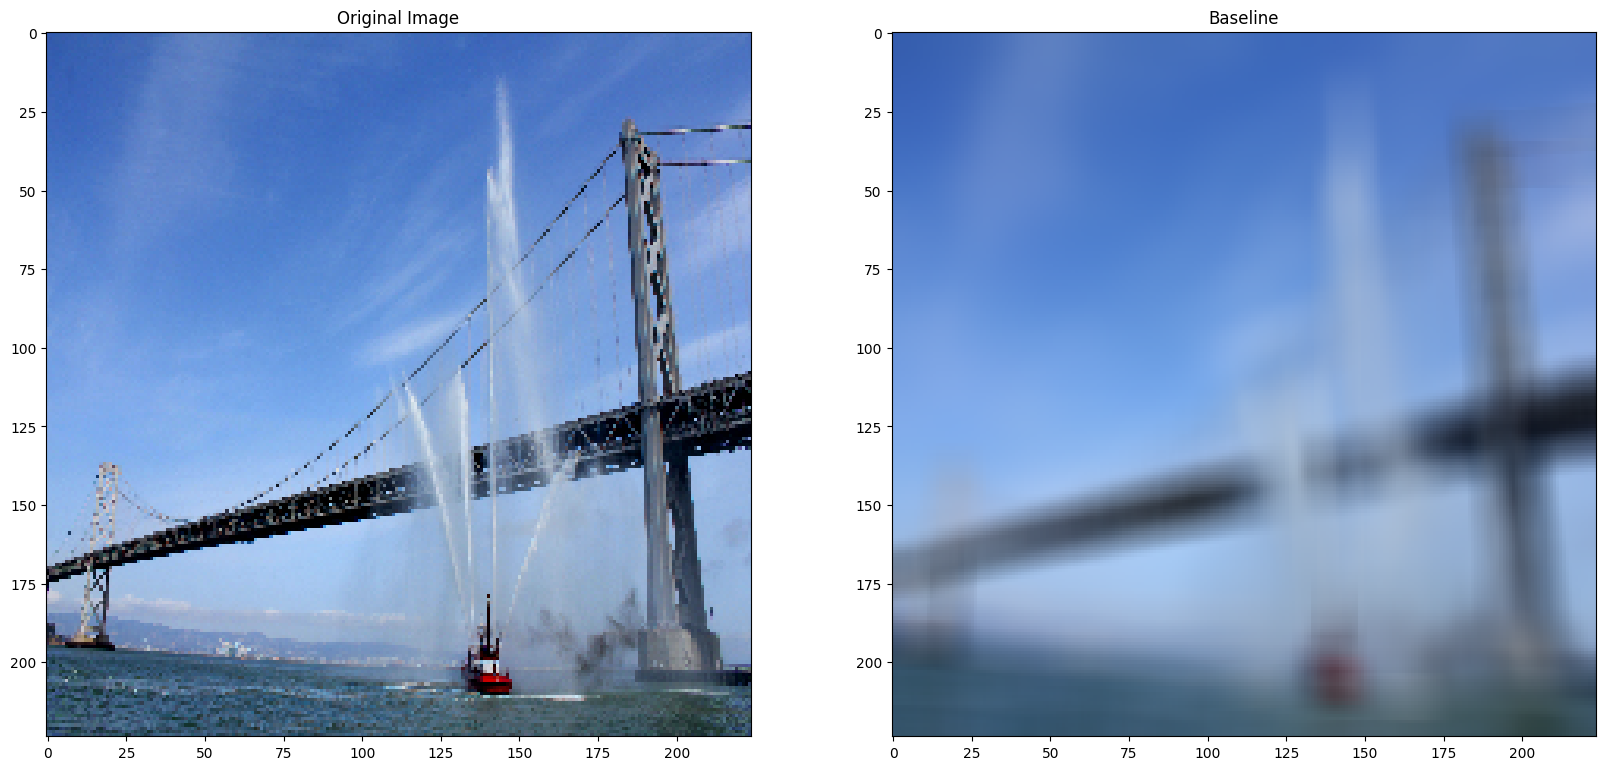

In [20]:

img = read_image("fireboat.jpg")
base = tf.image.resize(img, img_size)
base = tf.nn.avg_pool(base[None], ksize=15, strides=1, padding='SAME')[0]
print(type(img))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(base)
plt.title("Baseline")

In [21]:
def plot_img_attributions(base,
                          img,
                          class_index,
                          m_steps=10,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=base,
                                      image=img,
                                      class_index=class_index,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(10, 10))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(base)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(img)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title(f'Overlay [alpha = {overlay_alpha}]')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(img, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()

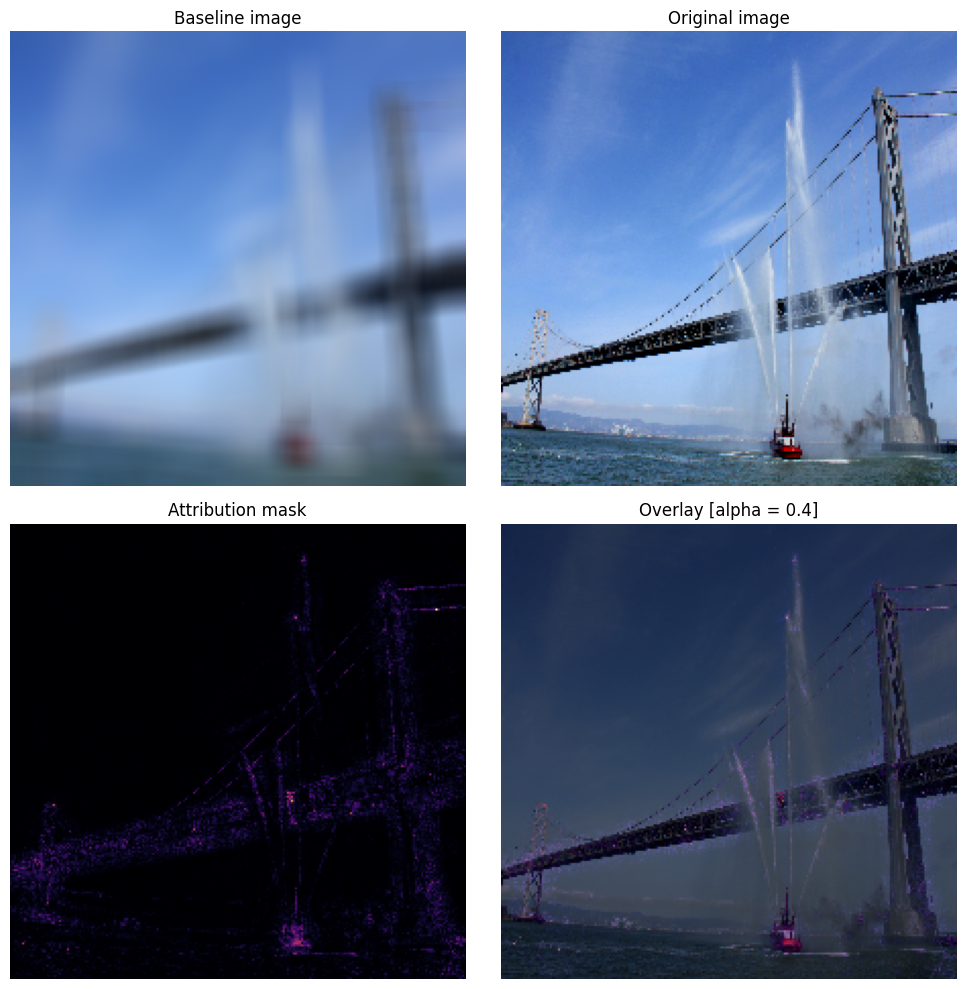

In [22]:
_ = plot_img_attributions(img=read_image(img_path),
                          base=base,
                          class_index=555,
                          m_steps=250,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

In [23]:
def create_advisaral_image_using_FGSM(input_image, input_label, pretrained_model, epsilon=0.1):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    adv_image = input_image + signed_grad * epsilon
    # clip adv_image from -1 to 1
    adv_image = tf.clip_by_value(adv_image, -1.0, 1.0)
    return adv_image

def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, img_size)
  image = preprocess_input(image)
  image = image[None, ...]
  return image

def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [24]:
pretrained_model = model
pretrained_model.trainable = False

input_image = tf.io.read_file(img_path)
input_image = tf.image.decode_image(input_image)
processed_image = preprocess(input_image)
image_probs = pretrained_model.predict(processed_image)

input_label = tf.one_hot(class_index, depth=1000)
input_label = tf.reshape(input_label, (1, 1000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


In [25]:
def get_class_index(model, image):
    pred = model(preprocess(image))
    return tf.argmax(pred[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


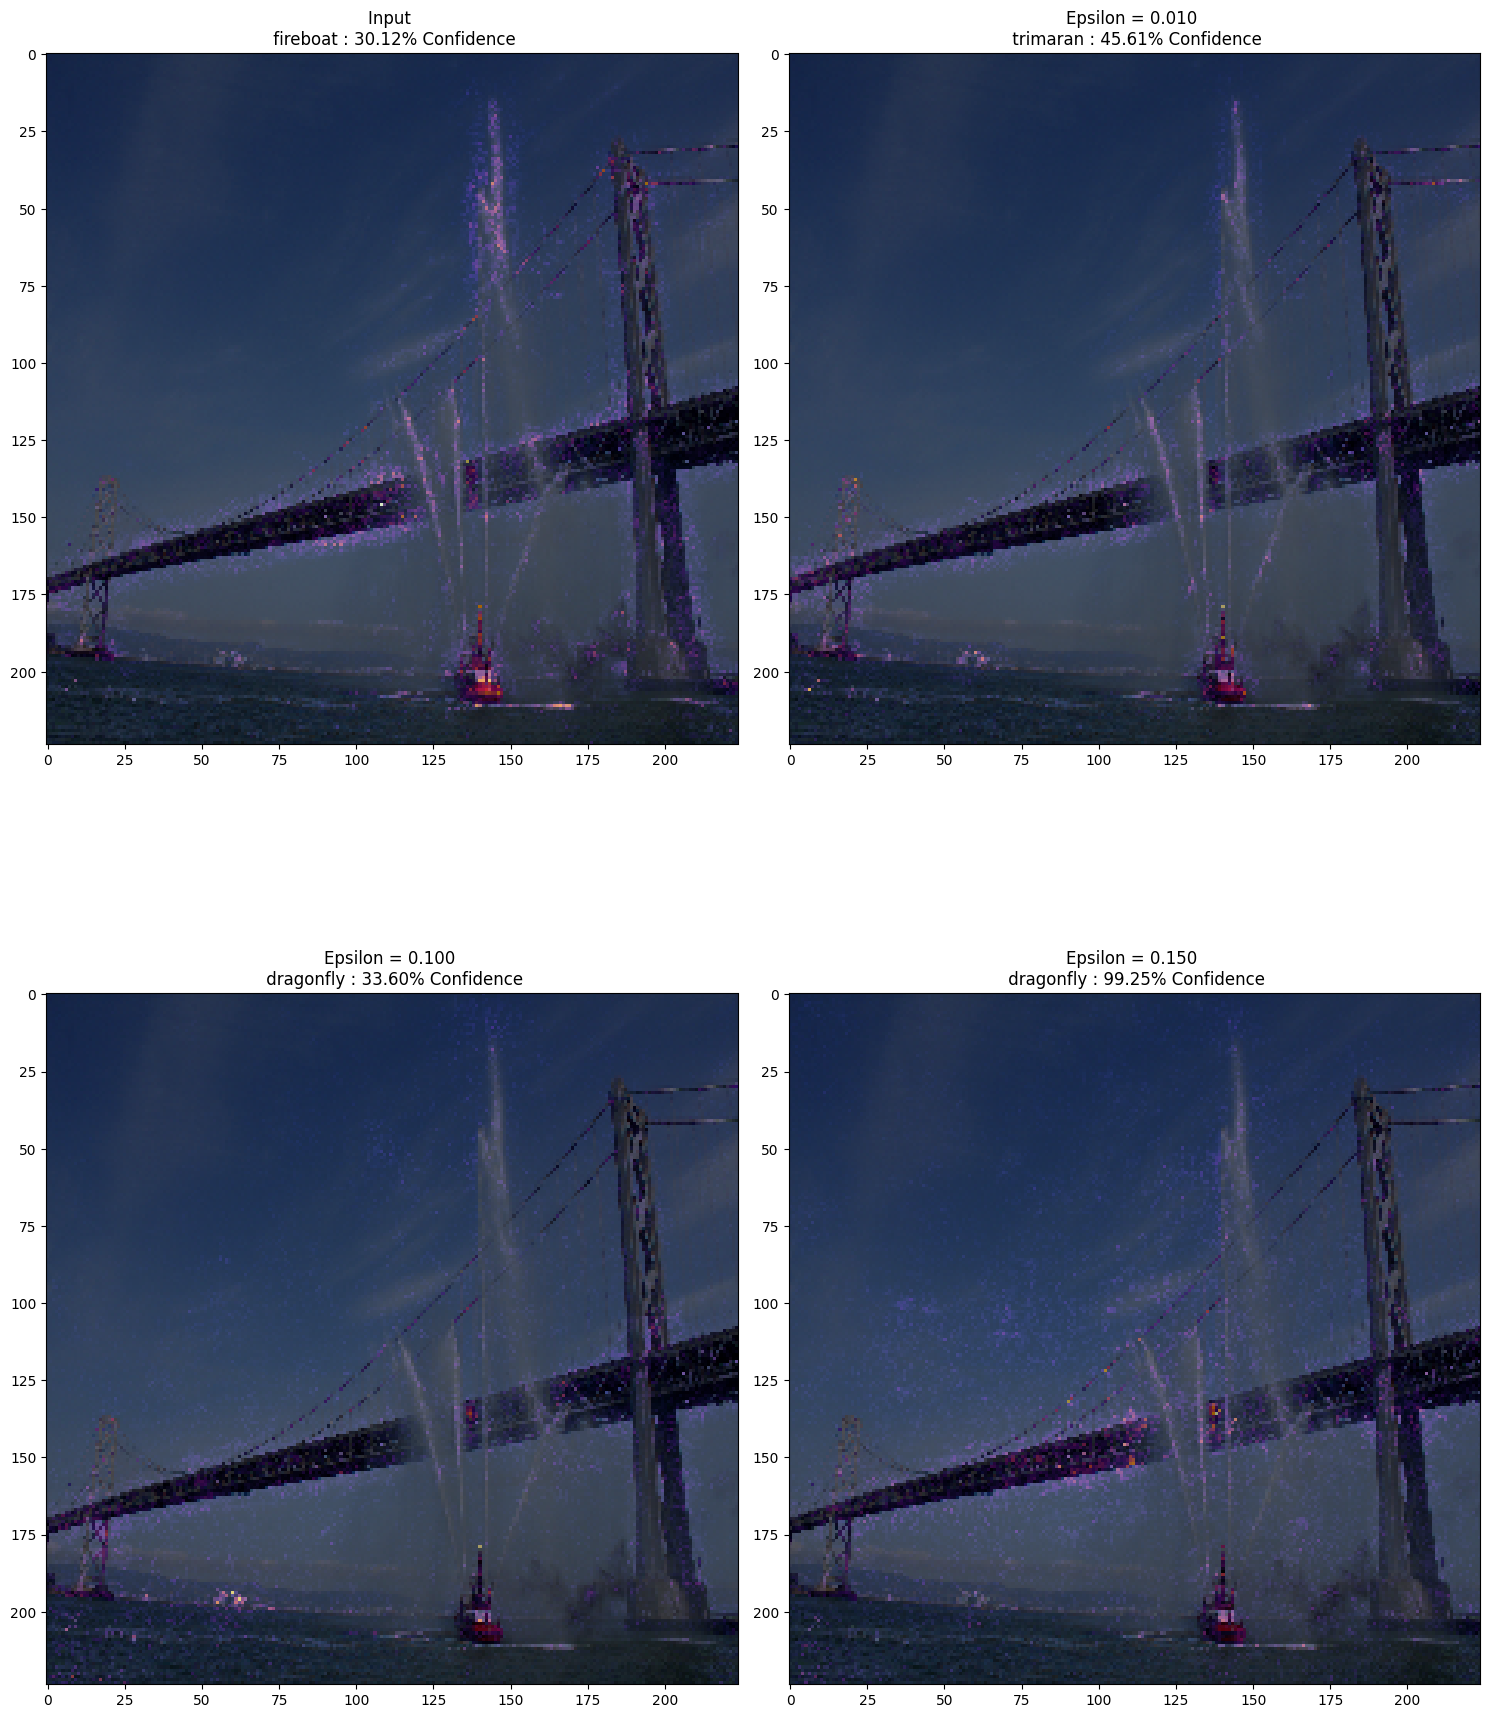

In [26]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

plt.figure(figsize=(15,20))

for eps in epsilons:
    # Create adversarial image using FGSM
    adv_image = create_advisaral_image_using_FGSM(processed_image, input_label, pretrained_model, epsilon=eps)
    
    # Convert tensor to numpy, rescale, and save as image
    adv_img_np = adv_image[0].numpy()  # remove batch dimension
    adv_img_np = ((adv_img_np * 127.5) + 127.5).astype(np.uint8)  # from [-1,1] to [0,255]
    adv_img_pil = PIL.Image.fromarray(adv_img_np)
    adv_img_pil.save("adv_img.jpg")

    plt.subplot(2, 2, (epsilons.index(eps) + 1))

    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_image))

    class_index = get_class_index(pretrained_model , adv_img_pil)

    attributions = integrated_gradients(baseline=base,
                                      image=read_image("adv_img.jpg"),
                                      class_index=class_index,
                                      m_steps=m_steps)
    
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    plt.title(f'Overlay [alpha = {alpha}]')
    plt.imshow(attribution_mask, cmap=plt.cm.inferno)
    plt.imshow(img, alpha=alpha)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[epsilons.index(eps)],
                                                    label, confidence*100))
plt.tight_layout()
plt.show()